# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

**Author: geoffroy.peeters@telecom-paris.fr**

**Modified by: bourhan.dernayka@telecom-paris.fr** (student)

**Version**: 2020/10/05 (changed to tensorfow.keras)

**Edit**: 2021/06/15, by Bourhan
    
For any remark or suggestion, please feel free to contact me.

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [3]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

colab = False
student = True

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zero-pad each sequence a length ```max_review_length```

In [4]:
top_words = 5000 
max_review_length = 100
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [5]:
# --- Import the IMDB data and only consider the ``top_words``` most used words
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

D:\Anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\Anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

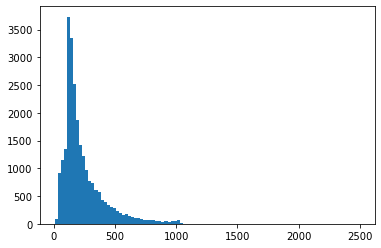

In [6]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [7]:
word_to_id = imdb.get_word_index()
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[(id-3)%top_words] for id in X_train[1000] ))

spain although i had seen bergman in a theater way back in bergman i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of bergman br br it turns out this is one of those films produced during the bergman that would go directly to video today the film stars bergman bergman kurt thomas as jonathan bergman bergman out of the blue to bergman the nation of bergman to enter and hopefully win the game a bergman bergman bergman by the khan who bergman his people by yelling what sounds like bergman power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess bergman who never speaks or leaves the house once trained tries to blend in with the bergman by wearing a bright red bergman with bergman of 

In [8]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [32]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [33]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [9]:
# --- truncate and pad input sequences

if student:
    # --- START CODE HERE (01)
    X_train = sequence.pad_sequences(X_train, max_review_length)
    X_test = sequence.pad_sequences(X_test, max_review_length)
    # --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]


# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (you should use ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [32]:
K.clear_session()

In [11]:
# --- create the model
# CODE-RNN1-2
if student:
    # --- START CODE HERE (02)
    # --- Using the Sequential API
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length))
    model.add(Lambda(lambda x: K.mean(x, axis=1)))
    model.add(Dense(1, activation='sigmoid'))
    # --- END CODE HERE
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
if student:
    # --- START CODE HERE (03)
    # --- Using the Functional API
    inputs = Input(shape=(max_review_length,))
    e = Embedding(top_words, embedding_vector_length)(inputs)
    m = Lambda(lambda x: K.mean(x, axis=1))(e)
    outputs = Dense(1)(m)
    model2 = Model(inputs=inputs, outputs=outputs) # name="mnist_model")
    # --- END CODE HERE

print(model2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 32)           160000    
_________________________________________________________________
lambda (Lambda)              (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 138us/sample - loss: 0.6402 - accuracy: 0.7172 - val_loss: 0.5638 - val_accuracy: 0.7774
Epoch 2/10
25000/25000 [==============================] - 2s 71us/sample - loss: 0.4877 - accuracy: 0.8143 - val_loss: 0.4403 - val_accuracy: 0.8230
Epoch 3/10
25000/25000 [==============================] - 2s 66us/sample - loss: 0.3946 - accuracy: 0.8456 - val_loss: 0.3853 - val_accuracy: 0.8375
Epoch 4/10
25000/25000 [==============================] - 2s 68us/sample - loss: 0.3477 - accuracy: 0.8595 - val_loss: 0.3594 - val_accuracy: 0.8438
Epoch 5/10
25000/25000 [==============================] - 2s 66us/sample - loss: 0.3194 - accuracy: 0.8700 - val_loss: 0.3457 - val_accuracy: 0.8481
Epoch 6/10
25000/25000 [==============================] - 2s 68us/sample - loss: 0.2996 - accuracy: 0.8774 - val_loss: 0.3399 - val_accuracy: 0.8495
Epoch 7/10
25000/25000 [==============================]

In [35]:
# --- compile and fit the functional model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 92us/sample - loss: 0.7435 - accuracy: 0.6188 - val_loss: 0.5989 - val_accuracy: 0.7952
Epoch 2/10
25000/25000 [==============================] - 2s 65us/sample - loss: 0.5156 - accuracy: 0.8208 - val_loss: 0.4405 - val_accuracy: 0.8265
Epoch 3/10
25000/25000 [==============================] - 2s 69us/sample - loss: 0.3948 - accuracy: 0.8498 - val_loss: 0.3928 - val_accuracy: 0.8445
Epoch 4/10
25000/25000 [==============================] - 2s 67us/sample - loss: 0.3516 - accuracy: 0.8654 - val_loss: 0.3855 - val_accuracy: 0.8468
Epoch 5/10
25000/25000 [==============================] - 2s 67us/sample - loss: 0.3254 - accuracy: 0.8736 - val_loss: 0.3896 - val_accuracy: 0.8509
Epoch 6/10
25000/25000 [==============================] - 2s 66us/sample - loss: 0.3066 - accuracy: 0.8798 - val_loss: 0.4003 - val_accuracy: 0.8516
Epoch 7/10
25000/25000 [==============================] 

## Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

In [224]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.42%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [21]:
great_id = word_to_id['worst']
great_embed = E[great_id]
dist = dict()
for i in range(E.shape[0]):
    vec = E[i]
    dist[i] = np.linalg.norm(vec-great_embed)
dist = dict(sorted(dist.items(), key=lambda item: item[1]))
[id_to_word[i] for i in list(dist.keys())[:5]]

['worst', 'waste', 'awful', 'dull', 'mess']

In [214]:
list(dist.keys())[:5]

[1315, 3460, 4244, 3896, 2691]

In [19]:
if student:
    # --- START CODE HERE (04)
    E = model.get_weights()[0]
    great_id = word_to_id['great']
    great_embed = E[great_id]
    dist = dict()
    for i in range(E.shape[0]):
        vec = E[i]
        dist[i] = np.linalg.norm(vec-great_embed)
    dist = dict(sorted(dist.items(), key=lambda item: item[1]))
    print([id_to_word[i] for i in list(dist.keys())[:5]])
    # --- END CODE HERE

['great', 'delight', 'favorites', 'enjoyable', 'outstanding']


out: 
great
fantastic
rare
outstanding
enjoyed

# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model 
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [36]:
K.clear_session()

In [45]:
# --- create the model

if student:
    # --- START CODE HERE (05)
    # --- Using the Sequential API
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    # --- END CODE HERE

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
if student:
    # --- START CODE HERE (06)
    # --- Using the Functional API
    inputs = Input(shape=(max_review_length,))
    e = Embedding(top_words, embedding_vector_length)(inputs) #input_lenght=max_review_length
    l = LSTM(128)(e)
    outputs = Dense(1)(l)
    model2 = Model(inputs=inputs, outputs=outputs) # name="mnist_model")
    # --- END CODE HERE

print(model2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# --- compile and fit the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 49s 2ms/sample - loss: 0.6431 - accuracy: 0.6832 - val_loss: 1.2134 - val_accuracy: 0.5183
Epoch 2/3
25000/25000 [==============================] - 47s 2ms/sample - loss: 0.5440 - accuracy: 0.7403 - val_loss: 0.5647 - val_accuracy: 0.7271
Epoch 3/3
25000/25000 [==============================] - 48s 2ms/sample - loss: 0.4642 - accuracy: 0.8122 - val_loss: 0.4847 - val_accuracy: 0.8316


In [47]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 59s 2ms/sample - loss: 0.2637 - accuracy: 0.8924 - val_loss: 0.3670 - val_accuracy: 0.8424
Epoch 2/3
25000/25000 [==============================] - 56s 2ms/sample - loss: 0.2351 - accuracy: 0.9068 - val_loss: 0.3723 - val_accuracy: 0.8337
Epoch 3/3
25000/25000 [==============================] - 57s 2ms/sample - loss: 0.2051 - accuracy: 0.9216 - val_loss: 0.3881 - val_accuracy: 0.8344


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.

In [25]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100)) 

Accuracy: 84.61%


## Predicting

In [63]:
case = np.random.randint(len(y_test))

print(' '.join(id_to_word[id] for id in X_test[case] ))
print()
print("Positive feedback" if model.predict_classes(X_test[case])[-1] else "Negative feedback")
print("Real:", end=" ")
print("Positive feedback" if y_test[case] else "Negative feedback")

she does a great job of playing the wife the director <UNK> <UNK> did not <UNK> to the typical hollywood <UNK> to give the film some <UNK> storyline it has not over <UNK> it's portrayal of the english middle class the films pace does not <UNK> although it is not a faced paced film a good twist in the plot that is not predictable a lovely english country village setting i enjoyed this film very much the locations were also very well <UNK> if you enjoy films about relationships this is one to watch better to have some <UNK> ready

Positive feedback
Real: Positive feedback


# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data Pre-Processing (01)
- 2) First model using the Sequential API (02)
- 3) First model using the Functional API (03)
- 4) Find equivalence between words (04)
- 5) Second model using the Sequential API (05)
- 6) Second model using the Functional API (06)
